# **Data Visualization**

## Objectives

* Answer business requirement 1:
  - The client requires us to do a study of their dataset and show them our results

## Inputs

* inputs/cats_vs_dogs_dataset/train
* inputs/cats_vs_dogs_dataset/validation
* inputs/cats_vs_dogs_dataset/test

## Outputs

* Image shape embeddings pickle file.
* Mean and standard deviation from the average images study
* Differentiate between cat and dog images
* Generate code to create an image montage on dashboard using images from the dataset

## Additional Comments

* 


---

# **Set directories for data**

## Import libraries

In [1]:
%pip install -r /workspace/pp5-cats-vs-dogs/requirements.txt 2>/dev/null | grep -v 'Requirement already satisfied'
print('Requirements installed.')

Note: you may need to restart the kernel to use updated packages.
Requirements installed.


In [2]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
import joblib
from tensorflow.keras.preprocessing import image


## Set working directory

Set working directory to root project folder

In [3]:
current_dir = os.getcwd()
print('Current folder: ' + current_dir)
os.chdir(os.path.dirname(current_dir))
root_dir = os.getcwd()
print('New folder: ' + root_dir)

Current folder: /workspace/pp5-cats-vs-dogs/jupyter_notebooks
New folder: /workspace/pp5-cats-vs-dogs


## Set input directories

In [4]:
dataset_folder = 'inputs/cats_vs_dogs_dataset'
train_path = dataset_folder + '/train'
validation_path = dataset_folder + '/validation'
test_path = dataset_folder + '/test'
train_path

'inputs/cats_vs_dogs_dataset/train'

## Set output directory

In [5]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(root_dir) and version in os.listdir(root_dir + '/outputs'):
    print(f'Version {version} is already available, change to a new version first.')
    pass
else:
    os.makedirs(name=file_path)
    print(f'New directory for version {version} has been created')

Version v1 is already available, change to a new version first.


## Set label names

In [6]:
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['cat', 'dog']


---

# **Data visualization of image data**

## Image shape

### Average image shape

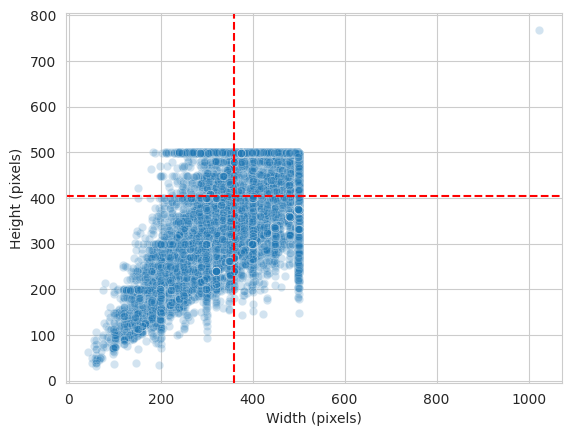

Width average: 404 
Height average: 360


In [7]:
dim1, dim2 = [], []
for label in labels:
    for image_filename in os.listdir(train_path + '/' + label):
        img = imread(train_path + '/' + label + '/' + image_filename)
        d1, d2, colors = img.shape
        dim1.append(d1)  # image height
        dim2.append(d2)  # image width

sns.set_style("whitegrid")
fig, axes = plt.subplots()
sns.scatterplot(x=dim2, y=dim1, alpha=0.2)
axes.set_xlabel("Width (pixels)")
axes.set_ylabel("Height (pixels)")
dim1_mean = int(np.array(dim1).mean())
dim2_mean = int(np.array(dim2).mean())
axes.axvline(x=dim1_mean, color='r', linestyle='--')
axes.axhline(y=dim2_mean, color='r', linestyle='--')
plt.show()
print(f"Width average: {dim2_mean} \nHeight average: {dim1_mean}")

### Save the image shape embeddings

In [8]:
image_shape = (dim1_mean, dim2_mean, 3)
joblib.dump(value=image_shape ,
            filename=f"{file_path}/image_shape.pkl")

['outputs/v1/image_shape.pkl']

---
## Average and variability

### Load images in an array

In [10]:
def load_image_as_array(my_data_dir, new_size=(50, 50), n_images_per_label=20):

    X, y = np.array([], dtype='int'), np.array([], dtype='object')
    labels = os.listdir(my_data_dir)

    for label in labels:
        counter = 0
        for image_filename in os.listdir(my_data_dir + '/' + label):
            # n_images_per_label: we set a limit, since it may take too much time
            if counter < n_images_per_label:

                img = image.load_img(
                    my_data_dir + '/' + label + '/' + image_filename, target_size=new_size)
                if image.img_to_array(img).max() > 1:
                    img_resized = image.img_to_array(img) / 255
                else:
                    img_resized = image.img_to_array(img)

                X = np.append(X, img_resized).reshape(-1,
                                                      new_size[0], new_size[1], img_resized.shape[2])
                y = np.append(y, label)
                counter += 1

    return X, y


X, y = load_image_as_array(my_data_dir=train_path,
                           new_size=image_shape,
                           n_images_per_label=8)
print(X.shape, y.shape)

(16, 360, 404, 3) (16,)


### Save or plot mean and variability of images

==== Label cat ====
Image Shape: (360, 404, 3)


==== Label dog ====
Image Shape: (360, 404, 3)


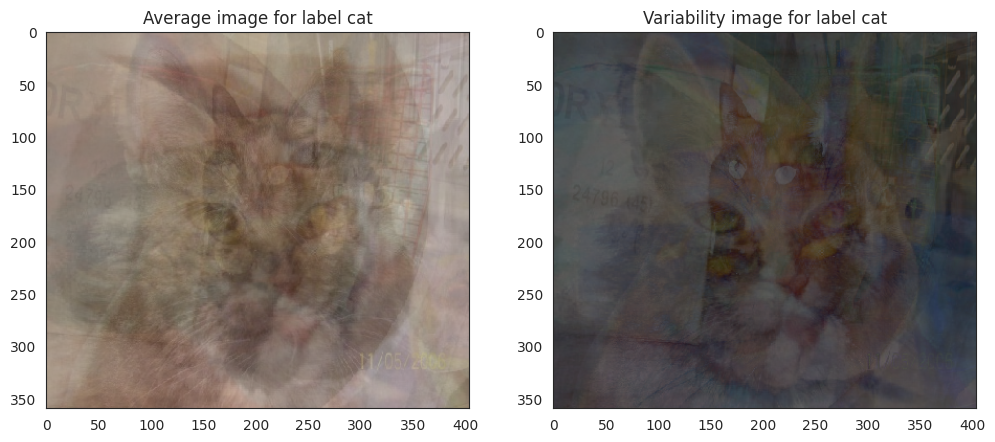

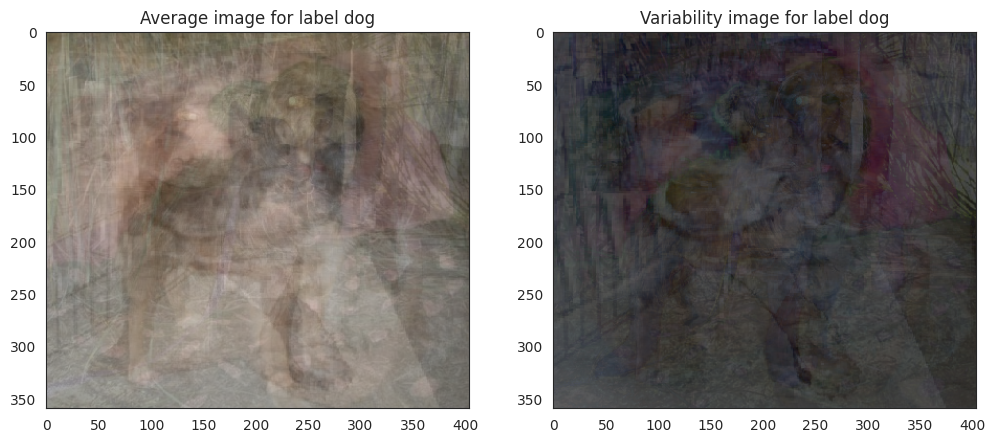

In [15]:
def plot_mean_variability_per_labels(X, y, figsize=(12, 5), save_image=False):
    """
    The pseudo-code for the function is:
    * Loop over all labels
    * Subset an array for a given label
    * Calculate the mean and standard deviation
    * Create a figure displaying the mean and variability of images
    * Save the image
    """

    for label_to_display in np.unique(y):
        sns.set_style("white")

        y = y.reshape(-1, 1, 1)
        boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
        arr = X[boolean_mask]

        avg_img = np.mean(arr, axis=0)
        std_img = np.std(arr, axis=0)
        print(f"==== Label {label_to_display} ====")
        print(f"Image Shape: {avg_img.shape}")
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
        axes[0].set_title(f"Average image for label {label_to_display}")
        axes[0].imshow(avg_img, cmap='Blues')
        axes[1].set_title(f"Variability image for label {label_to_display}")
        axes[1].imshow(std_img, cmap='Blues')

        if save_image:
            plt.savefig(f"{file_path}/avg_var_{label_to_display}.png",
                        bbox_inches='tight', dpi=150)
        else:
            plt.tight_layout()
            plt.show()


plot_mean_variability_per_labels(X=X, y=y, figsize=(12, 5), save_image=True)

### Differentiate between average cat and dog images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


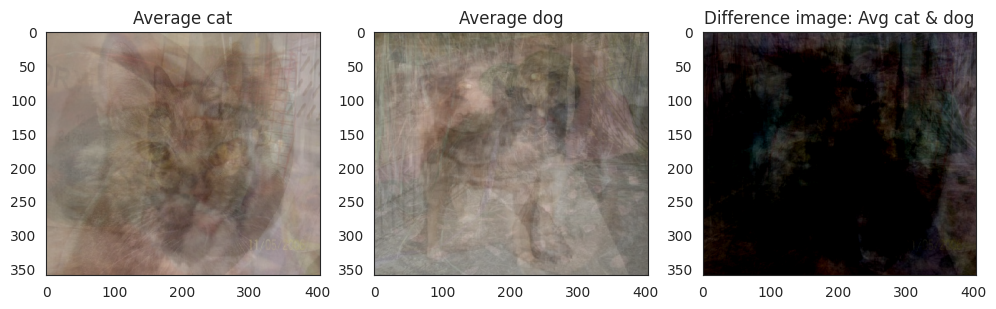

In [16]:
def subset_image_label(X, y, label_to_display):
    y = y.reshape(-1, 1, 1)
    boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
    df = X[boolean_mask]
    return df


def diff_bet_avg_image_labels_data_as_array(X, y, label_1, label_2, figsize=(20, 5), save_image=False):
    """
    Checks if the labels exist in the set of unique labels
    Calculates the mean and difference for label1 and label2
    Plots a chart and saves it if save_image=True
    """
    sns.set_style("white")

    if (label_1 not in np.unique(y)) or (label_2 not in np.unique(y)):
        print(
            f"Either label {label} or label {label_2}, are not in {np.unique(y)} ")
        return

    # calculate mean from label1
    images_label = subset_image_label(X, y, label_1)
    label1_avg = np.mean(images_label, axis=0)

    # calculate mean from label2
    images_label = subset_image_label(X, y, label_2)
    label2_avg = np.mean(images_label, axis=0)

    # calculate difference and plot difference, avg label1 and avg label2
    difference_mean = label1_avg - label2_avg
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    axes[0].imshow(label1_avg, cmap='Blues')
    axes[0].set_title(f'Average {label_1}')
    axes[1].imshow(label2_avg, cmap='Blues')
    axes[1].set_title(f'Average {label_2}')
    axes[2].imshow(difference_mean, cmap='Blues')
    axes[2].set_title(f'Difference image: Avg {label_1} & {label_2}')
    if save_image:
        plt.savefig(f"{file_path}/avg_diff.png", bbox_inches='tight', dpi=150)
    else:
        plt.tight_layout()
        plt.show()


diff_bet_avg_image_labels_data_as_array(X=X, y=y,
                                        label_1='cat', label_2='dog',
                                        figsize=(12, 10),
                                        save_image=True
                                        )

In [ ]:
def set_labels(labels):
    for i, label in enumerate(labels, 1):
        globals()[f'label_{i}'] = label

# Example usage:
labelst = ['cat', 'dog', 'parrot']
set_labels(labelst)

# Testing if the variables are set correctly
print(label_1)  # Output: cat
print(label_2)  # Output: dog
print(label_3)  # Output: parrot

---


# Push files to Repo

* In case you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [ ]:
import os
try:
  # create here your folder
  # os.makedirs(name='')
except Exception as e:
  print(e)


# Conclusions and Next Steps